In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import os

In [3]:
npys = glob('../data/**/*.npy', recursive=True)

df = pd.read_csv('../data/training_labels.csv')
df['id'] = df['id'].apply(lambda x: '../data/train/0/'+x+'.npy')
df = df[df.apply(lambda x: x['id'] in npys, axis=1)]

print(len(npys))
print(df.groupby('target').size())
df

158
target
0    81
1    77
dtype: int64


,id,target
0,../data/train/0/00000e74ad.npy,1
1,../data/train/0/00001f4945.npy,0
2,../data/train/0/0000661522.npy,0
3,../data/train/0/00007a006a.npy,0
4,../data/train/0/0000a38978.npy,1
...,...,...
1986,../data/train/0/00df6c7cc5.npy,0
1987,../data/train/0/00df81b3e1.npy,0
1988,../data/train/0/00dfb6a635.npy,1
1989,../data/train/0/00dfd3eab7.npy,1


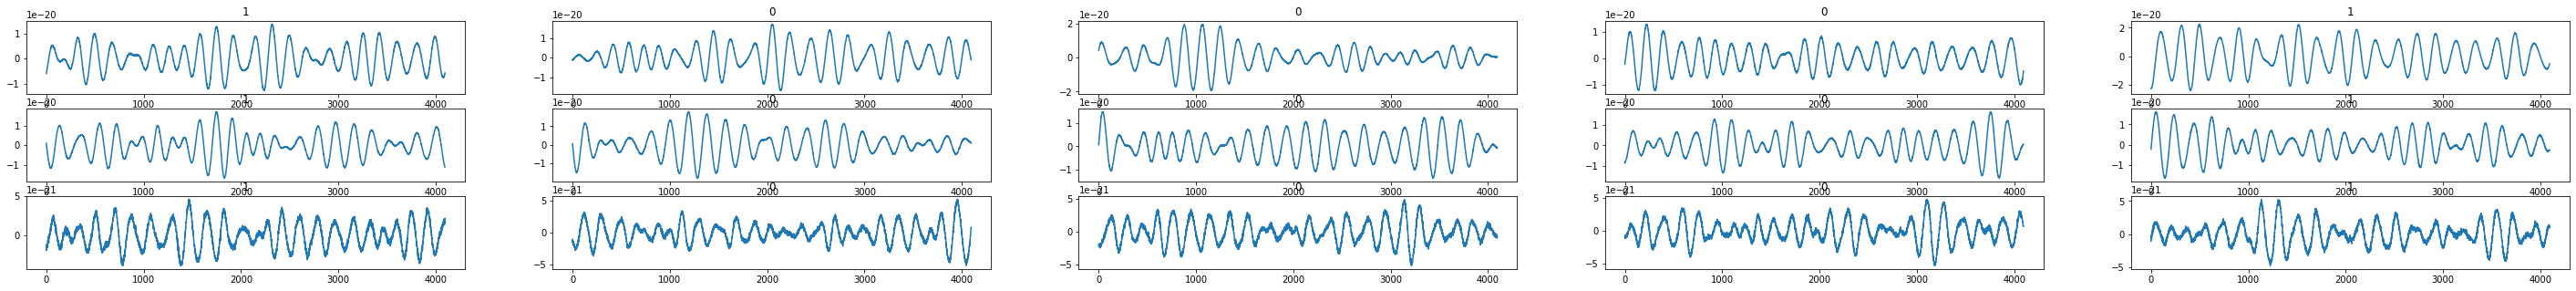

In [4]:
"""Remarks:
- Each detector yields different signal amplitude
- Third detector has noisy signal (thick curve)
- 
"""
axs = plt.subplots(3, 5, figsize=(50, 5))[1]
df = df.sample(frac=1.) # shuffle

for i in range(5):
    ts = np.load(df.loc[i, 'id'])
    for j in range(3):
        axs[j, i].plot(ts[j])
        axs[j, i].set_title(df.loc[i, 'target'])

plt.savefig('time_series.png')
plt.show()

In [10]:
from nnAudio.Spectrogram import STFT, CQT2010v2, MelSpectrogram
import torch

sampling rate = 2048. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.0933 seconds
(3, 256, 257)
(3, 256, 257)
(3, 256, 257)
(3, 256, 257)
(3, 256, 257)


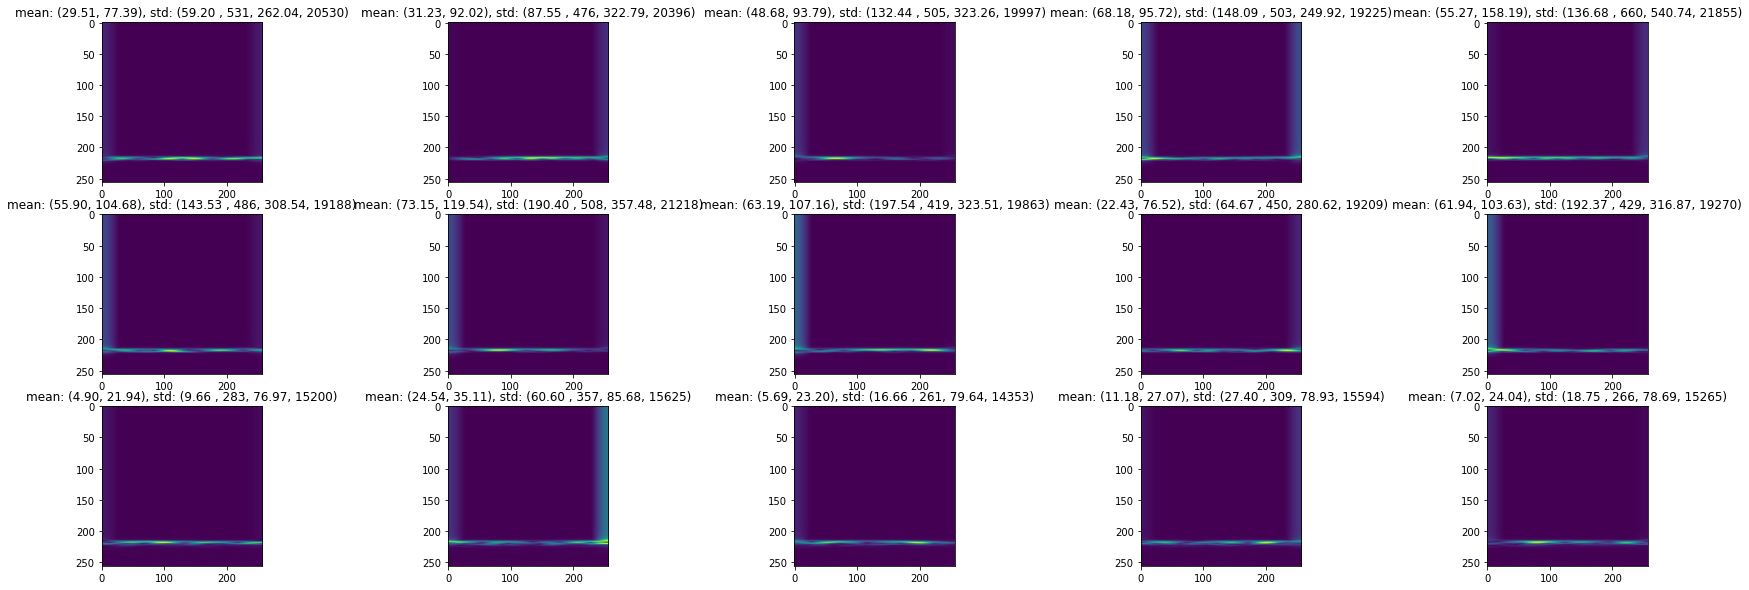

In [6]:
"""Remarks:
- freq_scale == log: depicts more than when using linear
- Lower frequencies are much more present than large ones; values are more diverse
- There is roughtly twice much unique values in the upper half of spec than in the bottom part
"""

stft = STFT(n_fft=1024, freq_bins=256, hop_length=16, window='hann',
                sr=2048, fmin=1e-10, fmax=1e3, center=True, 
                freq_scale='log', output_format='Magnitude', )
axs = plt.subplots(3, 5, figsize=(30, 10))[1]

for i in range(5):
    ts = np.load(df.loc[i, 'id'])
    spec = stft(torch.from_numpy(ts).float()).detach().numpy()*1e21
    print(spec.shape)
    for j in range(3):
        axs[j, i].imshow(spec[j])
        half = spec[j].shape[0]//2
        axs[j, i].set_title(f"mean: ({spec[j][:half].mean():.2f}, {spec[j][half:].mean():.2f}), std: ({spec[j][:half].std():.2f} , {np.unique(spec[j][:half]).shape[0]}, {spec[j][half:].std():.2f}, {np.unique(spec[j][half:]).shape[0]})")

plt.savefig('spectro_stft_magnitude.png')
plt.show()

sampling rate = 2048. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.0317 seconds
(3, 256, 257)
(3, 256, 257)
(3, 256, 257)
(3, 256, 257)
(3, 256, 257)


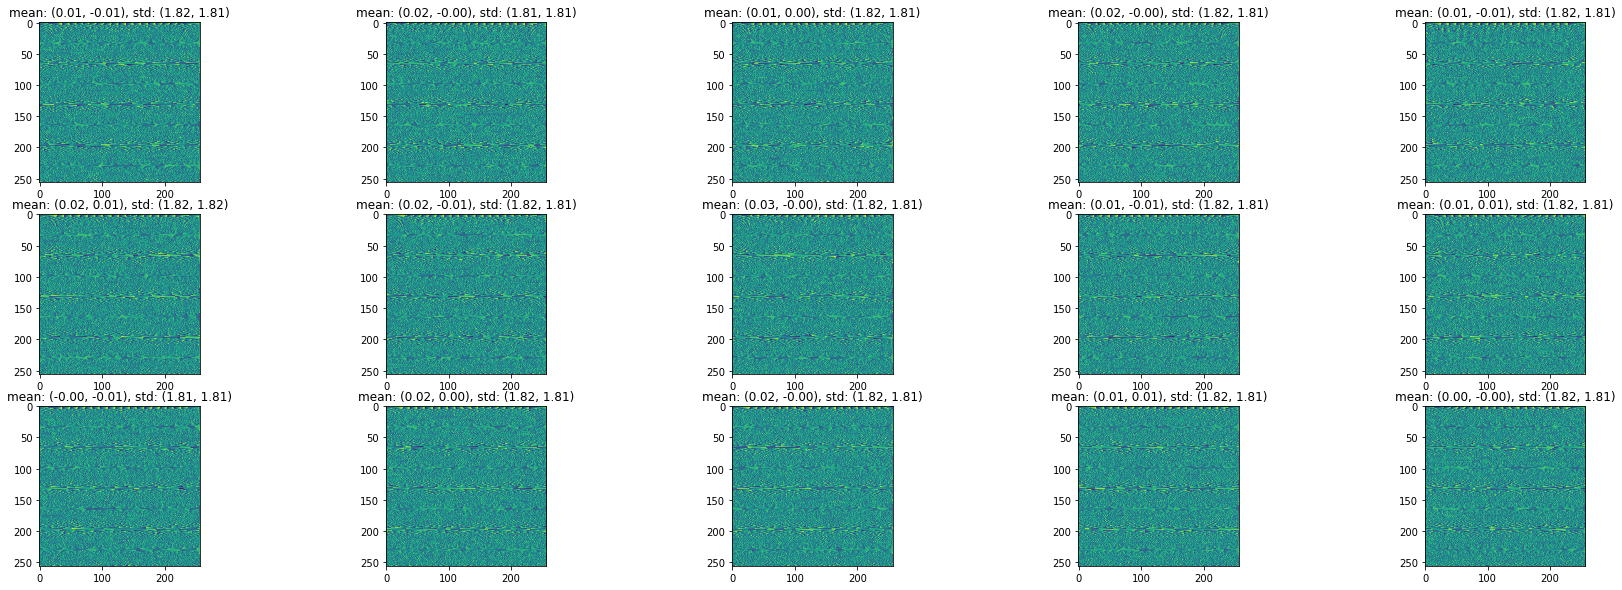

In [7]:
"""Remarks:
- all angles are uniformly distributed in the spec
"""

stft = STFT(n_fft=1024, freq_bins=256, hop_length=16, window='hann',
                sr=2048, fmin=0, fmax=500, center=True, 
                freq_scale='linear', output_format='Phase', )
axs = plt.subplots(3, 5, figsize=(30, 10))[1]

for i in range(5):
    ts = np.load(df.loc[i, 'id'])
    spec = stft(torch.from_numpy(ts).float()).detach().numpy()
    print(spec.shape)
    for j in range(3):
        axs[j, i].imshow(spec[j])
        half = spec[j].shape[0]//2
        axs[j, i].set_title(f"mean: ({spec[j][:half].mean():.2f}, {spec[j][half:].mean():.2f}), std: ({spec[j][:half].std():.2f}, {spec[j][half:].std():.2f})")

plt.savefig('spectro_stft_phase.png')
plt.show()

# CQT

(3, 256, 257)
(3, 256, 257)
(3, 256, 257)
(3, 256, 257)
(3, 256, 257)


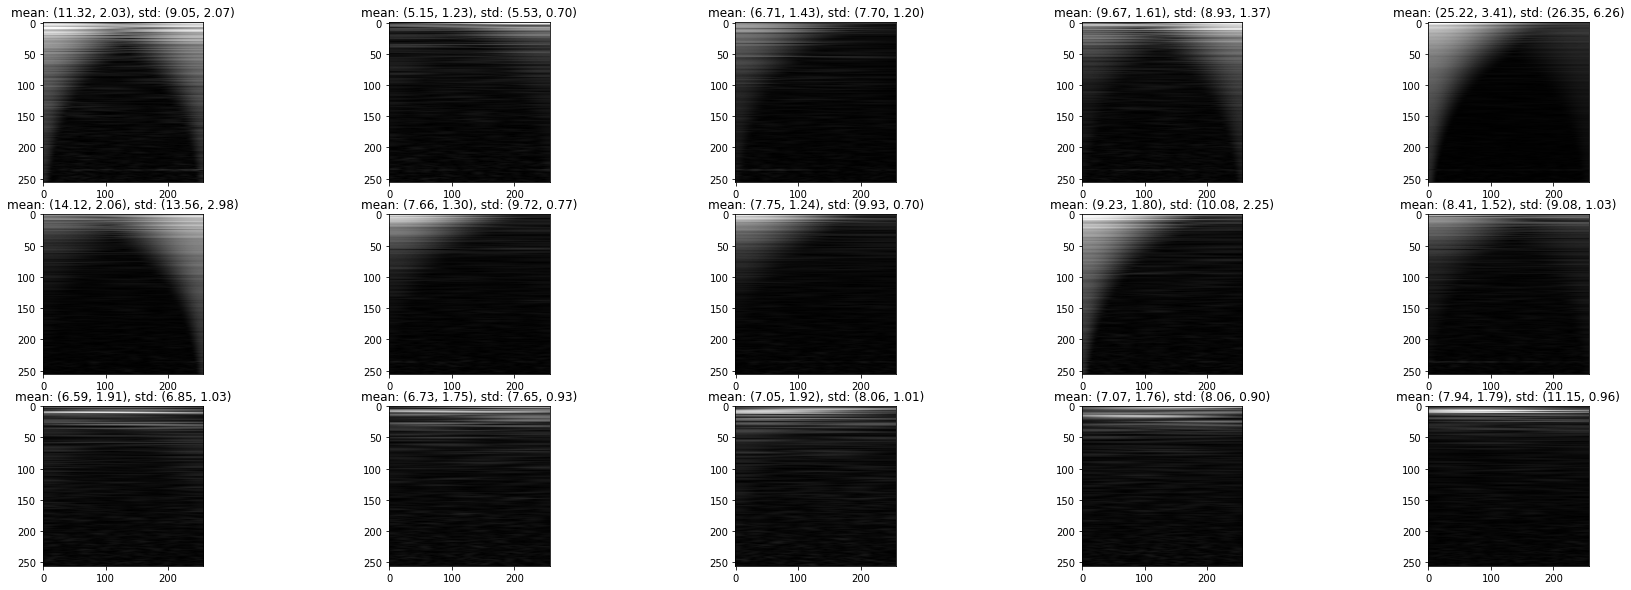

In [8]:
"""Remarks:
- 
"""

cqt = CQT2010v2(sr=2048, hop_length=16, fmin=20, n_bins=256, bins_per_octave=60, norm=True, basis_norm=1, 
                window='hann', pad_mode='constant', output_format='Magnitude', verbose=False  )
axs = plt.subplots(3, 5, figsize=(30, 10))[1]

for i in range(5):
    ts = np.load(df.loc[i, 'id'])
    spec = cqt(torch.from_numpy(ts).float()).detach().numpy()*1e22
    print(spec.shape)
    for j in range(3):
        axs[j, i].imshow(spec[j], cmap='gray')
        half = spec[j].shape[0]//2
        axs[j, i].set_title(f"mean: ({spec[j][:half].mean():.2f}, {spec[j][half:].mean():.2f}), std: ({spec[j][:half].std():.2f}, {spec[j][half:].std():.2f})")

plt.savefig('spectro_cqt_magnitude.png')
plt.show()

# Mels

STFT kernels created, time used = 0.0485 seconds
STFT filter created, time used = 0.0067 seconds
Mel filter created, time used = 0.0068 seconds
(3, 256, 257)
(3, 256, 257)
(3, 256, 257)
(3, 256, 257)
(3, 256, 257)


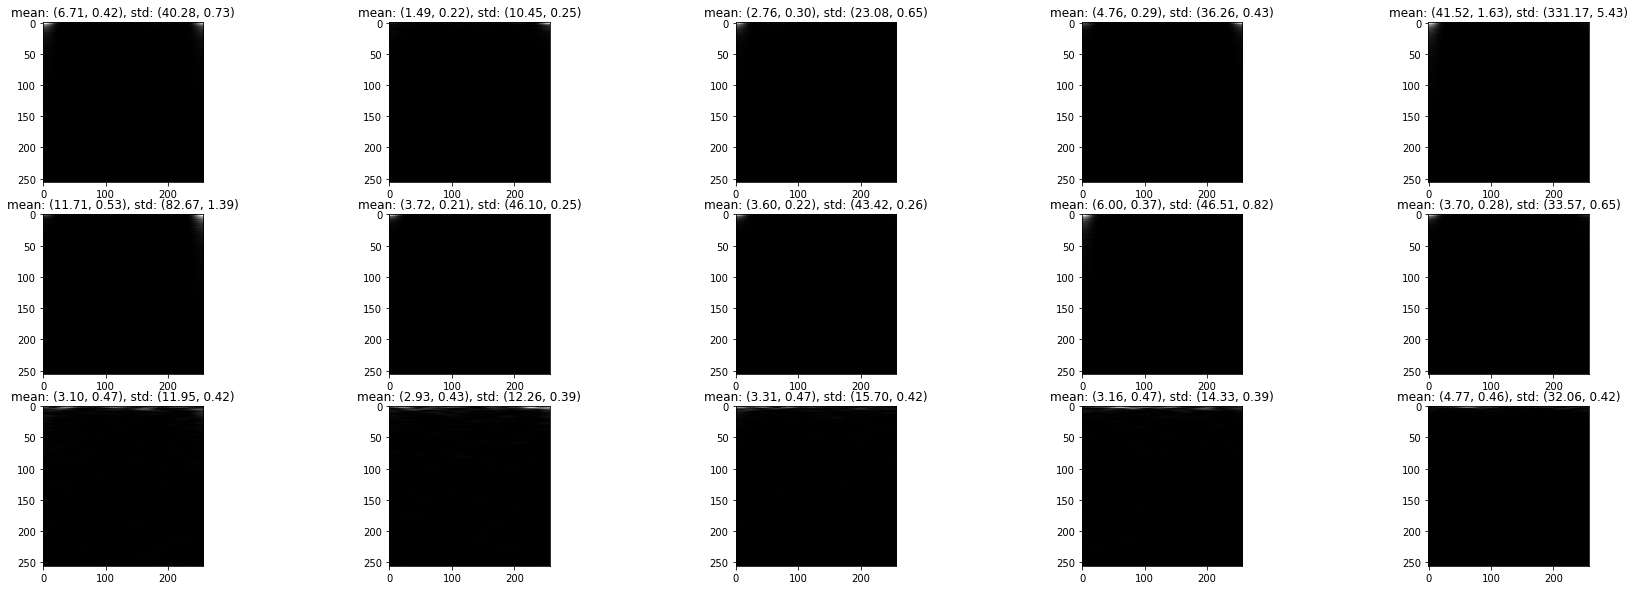

In [26]:
"""Remarks:
- 
"""

mel = MelSpectrogram(sr=2048, n_fft=1024, n_mels=256, hop_length=16, window='hann', center=True, pad_mode='constant', 
                htk=True, fmin=20, fmax=500,  verbose=True  )
axs = plt.subplots(3, 5, figsize=(30, 10))[1]

for i in range(5):
    ts = np.load(df.loc[i, 'id'])
    spec = mel(torch.from_numpy(ts).float()).detach().numpy()*1e41
    print(spec.shape)
    for j in range(3):
        axs[j, i].imshow(spec[j], cmap='gray')
        half = spec[j].shape[0]//2
        axs[j, i].set_title(f"mean: ({spec[j][:half].mean():.2f}, {spec[j][half:].mean():.2f}), std: ({spec[j][:half].std():.2f}, {spec[j][half:].std():.2f})")

plt.savefig('spectro_mel.png')
plt.show()